In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import pandas as pd
from legwork import utils, strain, psd, source
from astropy.coordinates import SkyCoord


In [2]:
!python CV_pop.py --max-distance 800 --mu-m1 0.7 --sigma-m1 0.005 --sigma-m2 0.005

In [3]:
dat = pd.read_csv('dat_maxDistance_800.txt')

In [4]:
dat = dat.rename(columns={'# m1[Msun]':'m1',
                          ' m2[Msun]':'m2',
                          ' inclination[rad]':'inc',
                          ' f_gw[Hz]':'f_gw',
                          ' x_galcen[kpc]':'x', 
                          ' y_galcen[kpc]':'y', 
                          ' z_galcen[kpc]':'z',
                          ' Pala_reassigned' : 'pala'})

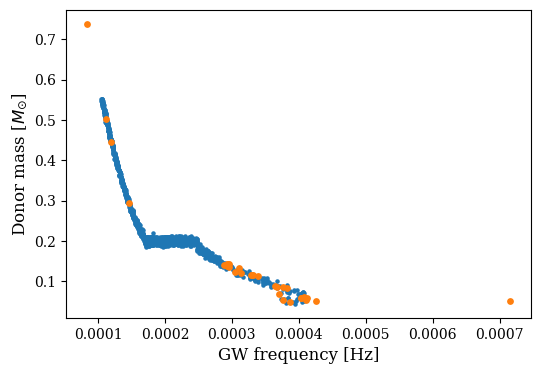

In [17]:
fig = plt.figure(figsize=(6, 4))
plt.scatter(dat['f_gw'], dat['m2'], s=5)
plt.scatter(dat.loc[dat.pala > 0].f_gw, dat.loc[dat.pala > 0].m2, s=15)
plt.xlabel('GW frequency [Hz]', size=12)
plt.ylabel('Donor mass [$M_{\odot}$]', size=12)
plt.tick_params('both', labelsize=10)

In [18]:
dist = np.sqrt(dat['x']**2 + dat['y']**2 + dat['z']**2).values * u.kpc
mc = utils.chirp_mass(dat['m1'].values * u.Msun, dat['m2'].values * u.Msun)

In [19]:
sources = source.Source(m_1=dat['m1'].values * u.Msun, m_2=dat['m2'].values * u.Msun, 
                        ecc=np.zeros_like(dat['m1'].values), dist=dist, f_orb=dat['f_gw'].values/2 * u.Hz,
                        interpolate_g=False)

In [20]:
snr = sources.get_snr()
ASD = strain.h_0_n(m_c=mc, f_orb=dat['f_gw'].values/2 * u.Hz,  
                   ecc=np.zeros(len(mc)), dist=dist, 
                   n=2, position=None, polarisation=None, 
                   inclination=None, interpolated_g=None) * np.sqrt(4 * 3.155e7)
    

In [22]:
ind, = np.where(dat.pala > 0)

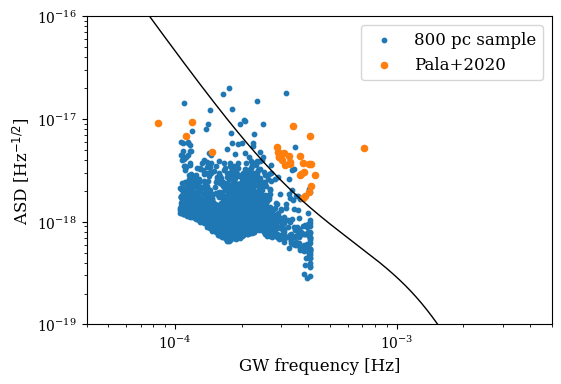

In [32]:
fig = plt.figure(figsize=(6, 4))


frequency_range = frequency_range=np.logspace(-5, 0, 1000) * u.Hz
LISA = psd.lisa_psd(frequency_range, approximate_R=False, confusion_noise='robson19')
plt.plot(frequency_range, LISA**0.5, lw=1, c='black')   
plt.scatter(dat.f_gw, ASD, s=10, label='800 pc sample')
plt.scatter(dat.loc[dat.pala > 0].f_gw, ASD[ind], s=20, label='Pala+2020')
plt.legend(prop={'size':12})
plt.yscale('log')
plt.xscale('log')
plt.xlim(4e-5, 5e-3)
plt.ylim(1e-19, 1e-16)
plt.xlabel('GW frequency [Hz]', size=12)
plt.ylabel('ASD [Hz$^{-1/2}$]', size=12)
plt.tick_params('both', labelsize=10)